In [2]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import pickle
from PIL import Image
import cv2
import numpy as np
import matplotlib as mpl
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter, binary_opening, binary_closing
import copy
import sys

# Get the parent directory of the current directory
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
    
from diffusion.unet import Unet, UpSample, DownSample, time_embedding
from diffusion.diffusion_proc import Diffusion, linear_noise_schedule
from diffusion.blocks import ResBlock, AttentionBlock, TimestepBlock, group_norm_layer

VOL_PATH = "/vol/bitbucket/ag323"

%matplotlib inline

## Model Arch

In [3]:
# def timestep_embedding(timesteps, dim, max_period=1000):
#     half = dim // 2
#     freqs = torch.exp(
#         -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
#     ).to(device=timesteps.device)
#     args = timesteps[:, None].float() * freqs[None]
#     embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
#     if dim % 2:
#         embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
#     return embedding

# class TimestepBlock(nn.Module):
#     @abstractmethod
#     def forward(self, x, emb):
#         """
#         Apply the module to `x` given `emb` timestep embeddings.
#         """

# class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
#     """
#     A sequential module that passes timestep embeddings to the children that
#     support it as an extra input.
#     """
#     def forward(self, x, t_emb, c_emb, mask):
#         for layer in self:
#             if(isinstance(layer, TimestepBlock)):
#                 x = layer(x, t_emb, c_emb, mask)
#             else:
#                 x = layer(x)
#             return x

# def norm_layer(channels):
#     return nn.GroupNorm(32, channels)

In [4]:
# class ResidualBlock(TimestepBlock):
#     def __init__(self, in_channels, out_channels, time_channels, cond_channels, dropout):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             norm_layer(in_channels),
#             nn.SiLU(),
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
#         )
        
#         self.time_emb = nn.Sequential(
#             nn.SiLU(),
#             nn.Linear(time_channels, out_channels)
#         )
        
#         self.cond_conv = nn.Sequential(
#             nn.Conv2d(cond_channels, out_channels, kernel_size=3, padding=1),
#             nn.SiLU()
#         )
        
#         self.conv2 = nn.Sequential(
#             norm_layer(out_channels),
#             nn.SiLU(),
#             nn.Dropout(p=dropout),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
#         )
        
#         if in_channels != out_channels:
#             self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
#         else:
#             self.shortcut = nn.Identity()
    
#     def forward(self, x, t, cond_img, mask):
#         h = self.conv1(x)
#         emb_t = self.time_emb(t)
#         emb_cond = self.cond_conv(cond_img) * mask[:, None, None, None]
#         h += (emb_t[:, :, None, None] + emb_cond)
#         h = self.conv2(h)
        
#         return h + self.shortcut(x)

In [5]:
# class AttentionBlock(nn.Module):
#     def __init__(self, channels, num_heads=1):
#         super().__init__()
#         self.num_heads = num_heads
#         assert channels % num_heads == 0
        
#         self.norm = norm_layer(channels)
#         self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
#         self.proj = nn.Conv2d(channels, channels, kernel_size=1)
        
#     def forward(self, x):
#         B, C, H, W = x.shape
#         qkv = self.qkv(self.norm(x))
#         q, k, v = qkv.reshape(B *  self.num_heads, -1, H * W).chunk(3, dim=1)
#         scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
#         attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
#         attn = attn.softmax(dim=-1)
#         h = torch.einsum("bts,bcs->bct", attn, v)
#         h = h.reshape(B, -1, H, W)
#         h = self.proj(h)
#         return h + x
    

In [6]:
# class UpSample(nn.Module):
#     def __init__(self, channels, use_conv):
#         super().__init__()
#         self.use_conv = use_conv
#         if use_conv:
#             self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    
#     def forward(self, x):
#         x = F.interpolate(x, scale_factor=2, mode="nearest")
#         if self.use_conv:
#             x = self.conv(x)
#         return x

# class DownSample(nn.Module):
#     def __init__(self, channels, use_conv):
#         super().__init__()
#         self.use_conv = use_conv
#         if use_conv:
#             self.op = nn.Conv2d(channels, channels, kernel_size=3, padding=1, stride=2)
#         else:
#             self.op = nn.AvgPool2d(stride=2)
    
#     def forward(self, x):
#         return self.op(x)

In [7]:
# class Unet(nn.Module):
#     def __init__(self, 
#                  in_channels=2,
#                  cond_channels=1,
#                  model_channels=128,
#                  out_channels=2,
#                  num_res_blocks=2, 
#                  attention_resolutions=(8, 16),
#                  dropout=0,
#                  channel_mult=(1, 2, 2, 2),
#                  conv_resample=True,
#                  num_heads=4):
#         super().__init__()
#         self.in_channels = in_channels
#         self.cond_channels = cond_channels
#         self.model_channels = model_channels
#         self.out_channels = out_channels
#         self.num_res_blocks = num_res_blocks
#         self.attention_resolutions = attention_resolutions,
#         self.dropout = dropout
#         self.channel_mult = channel_mult,
#         self.conv_resample = conv_resample
#         self.num_heads = num_heads
        
#         # time embedding
#         time_emb_dim = model_channels * 4
#         self.time_emb = nn.Sequential(
#             nn.Linear(model_channels, time_emb_dim),
#             nn.SiLU(),
#             nn.Linear(time_emb_dim, time_emb_dim)
#         )
        
#         # down blocks
#         self.down_blocks = nn.ModuleList([
#             TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
#         ])
#         down_block_channels = [model_channels]
#         ch = model_channels
#         ds = 1
#         for level, mult in enumerate(channel_mult):
#             for _ in range(num_res_blocks):
#                 layers = [ResidualBlock(ch, model_channels * mult, time_emb_dim, cond_channels, dropout)]
#                 ch = model_channels * mult
#                 if ds in attention_resolutions:
#                     layers.append(AttentionBlock(ch, num_heads))
#                 self.down_blocks.append(TimestepEmbedSequential(*layers))
#                 down_block_channels.append(ch)
#             if level != len(channel_mult) - 1:
#                 self.down_blocks.append(TimestepEmbedSequential(DownSample(ch, conv_resample)))
#                 down_block_channels.append(ch)
#                 ds *= 2
        
#         # middle blocks
#         self.middle_blocks = TimestepEmbedSequential(
#             ResidualBlock(ch, ch, time_emb_dim, cond_channels, dropout),
#             AttentionBlock(ch, num_heads),
#             ResidualBlock(ch, ch, time_emb_dim, cond_channels, dropout)
#         )
        
#         # up blocks
#         self.up_blocks = nn.ModuleList([])
#         for level, mult in enumerate(channel_mult[::-1]):
#             for i in range(num_res_blocks + 1):
#                 layers = [
#                     ResidualBlock(ch + down_block_channels.pop(), model_channels * mult, time_emb_dim, cond_channels, dropout)]
#                 ch = model_channels * mult
#                 if ds in attention_resolutions:
#                     layers.append(AttentionBlock(ch, num_heads))
#                 if level != len(channel_mult) - 1 and i == num_res_blocks:
#                     layers.append(UpSample(ch, conv_resample))
#                     ds //= 2
#                 self.up_blocks.append(TimestepEmbedSequential(*layers))
                
#         self.out = nn.Sequential(
#             norm_layer(ch),
#             nn.SiLU(),
#             nn.Conv2d(ch, out_channels, kernel_size=3, padding=1)
#         )
    
#     def forward(self, x, timesteps, cond_img, mask):
#         """
#         Apply the model to an input batch.
#         :param x: an [N x C x H x W] Tensor of inputs.
#         :param timesteps: a 1-D batch of timesteps.
#         :param cond_img: a [N x cond_C x H x W] Tensor of conditional images.
#         :param mask: a 1-D batch of conditioned/unconditioned.
#         :return: an [N x C x ...] Tensor of outputs.
#         """
#         hs = []
#         # time step embedding
#         t_emb = self.time_emb(timestep_embedding(timesteps, dim=self.model_channels))
        
#         # down step
#         h = x
#         for module in self.down_blocks:
#             if cond_img.shape[2:] != h.shape[2:]:
#                 cond_img = F.interpolate(cond_img, size=h.shape[2:], mode='nearest')
#             h = module(h, t_emb, cond_img, mask)
#             hs.append(h)
#         # mid stage
#         if cond_img.shape[2:] != h.shape[2:]:
#             cond_img = F.interpolate(cond_img, size=h.shape[2:], mode='nearest')
#         h = self.middle_blocks(h, t_emb, cond_img, mask)
        
#         # up stage
#         for module in self.up_blocks:
#             h_skip = hs.pop()
            
#             if h.shape[2:] != h_skip.shape[2:]:
#                 h = F.interpolate(h, size=h_skip.shape[2:], mode='nearest')

#             if cond_img.shape[2:] != h.shape[2:]:
#                 cond_img = F.interpolate(cond_img, size=h.shape[2:], mode='nearest')

#             cat_in = torch.cat([h, h_skip], dim=1)
#             h = module(cat_in, t_emb, cond_img, mask)
        
#         return self.out(h)

In [8]:
# # beta schedule
# def linear_beta_schedule(timesteps):
#     scale = 1000 / timesteps
#     beta_start = scale * 0.0001
#     beta_end = scale * 0.02
#     return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

# def sigmoid_beta_schedule(timesteps):
#     betas = torch.linspace(-6, 6, timesteps)
#     betas = torch.sigmoid(betas) / (betas.max() - betas.min()) * (0.02 - betas.min()) / 10
#     return betas

# def cosine_beta_schedule(timesteps, s=0.008):
#     steps = timesteps + 1
#     x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
#     alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
#     alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
#     betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
#     return torch.clip(betas, 0, 0.999)

In [9]:
# class GaussianDiffusion:
#     def __init__(
#         self,
#         timesteps=1000,
#         beta_schedule='linear',
#     ):
#         self.timesteps = timesteps
        
#         if beta_schedule == 'linear':
#             betas = linear_beta_schedule(timesteps)
#         elif beta_schedule == 'cosine':
#             betas = cosine_beta_schedule(timesteps)
#         elif beta_schedule == 'sigmoid':
#             betas = sigmoid_beta_schedule(timesteps)
#         else:
#             raise ValueError(f'Unknown beta schedule {beta_schedule}')
        
#         self.betas = betas
        
#         self.alphas = 1. - self.betas
#         self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
#         self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        
#         # calculations for diffusion q(x_t | x_{t-1}) and others
#         self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
#         self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
#         self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
#         self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
#         self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        
#         # calculations for posterior q(x_{t-1} | x_t, x_0)
#         self.posterior_variance = (
#             self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
#         )
#         self.posterior_log_variance_clipped = torch.log(
#             torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
#         )
        
#         self.posterior_mean_coef1 = (
#             self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
#         )
#         self.posterior_mean_coef2 = (
#             (1.0 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1.0 - self.alphas_cumprod)
#         )
    
#     # get the param of given timestep t
#     def _extract(self, a, t, x_shape):
#         batch_size = t.shape[0]
#         out = a.to(t.device).gather(0, t).float()
#         out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
#         return out
    
#     # forward diffusion : q(x_t | x_0)
#     def q_sample(self, x_start, t, noise=None):
#         if noise is None:
#             noise = torch.randn_like(x_start)
        
#         sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
#         sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        
#         return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
#     # mean and variance of q(x_t | x_0)
#     def q_mean_variance(self, x_start, t):
#         mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
#         variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
#         log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
#         return mean, variance, log_variance
    
#     # mean and variance of diffusion posterior: q(x_{t-1} | x_t, x_0)
#     def q_posterior_mean_variance(self, x_start, x_t, t):
#         posterior_mean = (
#             self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
#         )
#         posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
#         posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
#         return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
#     # compute x_0 from x_t and pred noise: reverse of q_sample
#     def predict_start_from_noise(self, x_t, t, noise):
#         return (
#             self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
#         )
    
#     # compute predicted mean and variance of p(x_{t-1} | x_t) 
#     def p_mean_variance(self, model, x_t, t, cond_img, w, clip_denoised=True):
#         device = next(model.parameters()).device
#         batch_size = x_t.shape[0]
        
#         # noise prediction from model
#         pred_noise_cond = model(x_t, t, cond_img, torch.ones(batch_size).int().to(device))
#         pred_noise_uncond = model(x_t, t, cond_img, torch.zeros(batch_size).int().to(device))
#         pred_noise = (1 + w) * pred_noise_cond - w * pred_noise_uncond
        
#         # get predicted x_0
#         x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
#         if clip_denoised:
#             x_recon = torch.clamp(x_recon, min=-1., max=1.)
#         model_mean, posterior_variance, posterior_log_variance = self.q_posterior_mean_variance(x_recon, x_t, t)
        
#         return model_mean, posterior_variance, posterior_log_variance
    
#     # denoise step: sample x_{t-1} from x_t and pred noise
#     @torch.no_grad()
#     def p_sample(self, model, x_t, t, cond_img, w, clip_denoised=True):
#         # pred mean and variance
#         model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t, cond_img, w, clip_denoised=clip_denoised)
        
#         noise = torch.randn_like(x_t)
#         # no noise when t = 0 
#         nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
#         # compute x_{t-1}
#         pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
#         return pred_img
    
#     # denoise : reverse diffusion
#     @torch.no_grad()
#     def p_sample_loop(self, model, shape, cond_img, w=2, clip_denoised=True):
#         batch_size = shape[0]
#         device = next(model.parameters()).device
        
#         # start from pure noise
#         img = torch.randn(shape, device=device)
#         imgs = []
#         for i in tqdm(reversed(range(0, self.timesteps)), desc='sampling loop time step', total=self.timesteps):
#             img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long), cond_img, w, clip_denoised)
#             imgs.append(img.cpu().numpy())
#         return imgs
    
#     # sample new images
#     @torch.no_grad
#     def sample(self, model, image_size, cond_img, batch_size=8, channels=3, w=2, clip_denoised=True):
#         return self.p_sample_loop(model, (batch_size, channels, image_size, image_size), cond_img, w, clip_denoised)
    
#     # use ddim to sample
#     @torch.no_grad()
#     def ddim_sample(
#         self,
#         model,
#         image_size,
#         cond_img,
#         batch_size=8,
#         channels=3,
#         ddim_timesteps=50,
#         w=2,
#         ddim_discr_method="uniform",
#         ddim_eta=0.0,
#         clip_denoised=True):
        
#         # make ddim timestep sequence
#         if ddim_discr_method == 'uniform':
#             c = self.timesteps // ddim_timesteps
#             ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
#         elif ddim_discr_method == 'quad':
#             ddim_timestep_seq = (
#                 (np.linspace(0, np.sqrt(self.timesteps * .8), ddim_timesteps)) ** 2
#             ).astype(int)
#         else:
#             raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')
#         # add one to get the final alpha values right (the ones from first scale to data during sampling)
#         ddim_timestep_seq = ddim_timestep_seq + 1
#         # previous sequence
#         ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])
        
#         device = next(model.parameters()).device
        
#         # start from pure noise (for each example in the batch)
#         sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
#         seq_img = [sample_img.cpu().numpy()]   
        
#         for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
#             t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
#             prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)
            
#             # 1. get current and previous alpha_cumprod
#             alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
#             alpha_cumprod_t_prev = self._extract(self.alphas_cumprod, prev_t, sample_img.shape)
    
#             # 2. predict noise using model
#             pred_noise_cond = model(sample_img, t, cond_img, torch.ones(batch_size).int().cuda())
#             pred_noise_uncond = model(sample_img, t, cond_img, torch.zeros(batch_size).int().cuda())
#             pred_noise = (1+w)*pred_noise_cond - w*pred_noise_uncond
            
#             # 3. get the predicted x_0
#             pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
#             if clip_denoised:
#                 pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)
            
#             # 4. compute variance: "sigma_t(η)" -> see formula (16)
#             # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
#             sigmas_t = ddim_eta * torch.sqrt(
#                 (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))
            
#             # 5. compute "direction pointing to x_t" of formula (12)
#             pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise
            
#             # 6. compute x_{t-1} of formula (12)
#             x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

#             sample_img = x_prev

#         return sample_img.cpu().numpy()
    
#     # compute train losses
#     def train_losses(self, model, x_start, t, cond_img, mask_c):
#         # generate random noise
#         noise = torch.randn_like(x_start)
#         # get x_t
#         x_noisy = self.q_sample(x_start, t, noise=noise)
#         predicted_noise = model(x_noisy, t, cond_img, mask_c)
#         loss = F.mse_loss(noise, predicted_noise)
#         return loss 

## Dataset

In [10]:
class CondSeqImageDataset(Dataset):
    def __init__(self, data_dir, transform=None, conditional_offset=5):
        self.data_dir = data_dir
        self.transform = transform
        self.conditional_offset = conditional_offset
        self.cond_images = []
        self.target_images = []
        self._load_data()

    def _load_data(self):
        files = sorted([os.path.join(self.data_dir, f) for f in os.listdir(self.data_dir) if f.endswith('.mpy')])
        for file in files:
            with open(file, 'rb') as f:
                images = pickle.load(f)
                if isinstance(images, list):
                    images = np.array(images)
                    
                for img_idx in range(len(images) - self.conditional_offset):
                    self.cond_images.append(images[img_idx])
                    self.target_images.append(images[img_idx + self.conditional_offset])

    def __len__(self):
        return len(self.cond_images)

    def __getitem__(self, idx):
        cond_image = self.cond_images[idx]
        image = self.target_images[idx]

        if self.transform:
            image = self.transform(image)
            cond_image = self.transform(cond_image)

        return image, cond_image

In [11]:
batch_size = 32
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5]),
    # transforms.Resize(64)
])

DATA_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data/simulated_bin_frames" # os.path.join(VOL_PATH, "diss_ag/data/simulated_bin_frames")
RESULT_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results" # os.path.join(VOL_PATH, "diss_ag/results/")
CKPT_DIR =  "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts" # os.path.join(VOL_PATH, "diss_ag/results/ckpts") 

# MNIST DATA
dataset = CondSeqImageDataset(DATA_DIR, transform=transform)

# Split dataset into training and testing
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Unet(
    in_ch=1,
    cond_ch=1,
    model_ch=96,
    output_ch=1,
    channel_mult=(1, 2, 2),
    attn_res=[],
)
model.to(device)

Unet(
  (time_emb): Sequential(
    (0): Linear(in_features=96, out_features=384, bias=True)
    (1): SiLU()
    (2): Linear(in_features=384, out_features=384, bias=True)
  )
  (downsample_blocks): ModuleList(
    (0): TimestepSeqEmbedding(
      (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepSeqEmbedding(
      (0): ResBlock(
        (conv_1): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (time_embedding): Sequential(
          (0): SiLU()
          (1): Linear(in_features=384, out_features=96, bias=True)
        )
        (condition_conv): Sequential(
          (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): SiLU()
        )
        (conv_2): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(

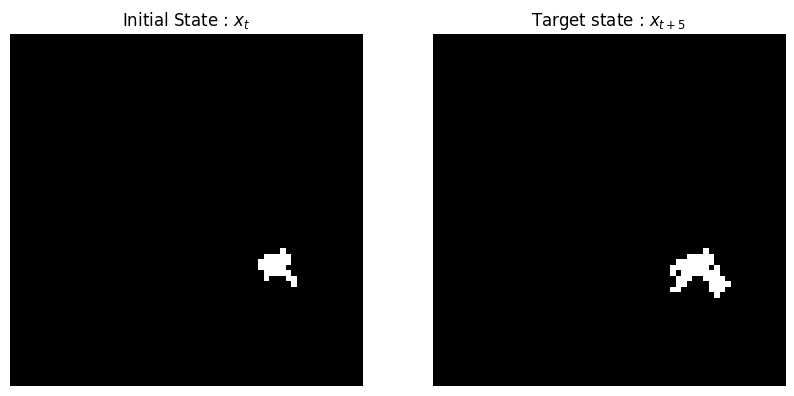

In [12]:
import random 

def plot_random_sample(dataset):
    # Get a random index
    random_idx = random.randint(0, len(dataset) - 1)
    # random_idx = 30
    
    
    # Get the image and conditional image
    image, cond_image = dataset[random_idx]
    
    # Convert to numpy arrays for plotting
    image = image.numpy().transpose(1, 2, 0)  # Transpose from (C, H, W) to (H, W, C)
    cond_image = cond_image.numpy().transpose(1, 2, 0)  # Transpose from (C, H, W) to (H, W, C)
    
    # Denormalize the images
    image = (image * 0.5 + 0.5).clip(0, 1)
    cond_image = (cond_image * 0.5 + 0.5).clip(0, 1)
    
    # Plot the images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[1].imshow(image, cmap='gray')
    axs[1].set_title("Target state : $x_{t+5}$")
    axs[1].axis('off')
    
    axs[0].imshow(cond_image, cmap='gray')
    axs[0].set_title("Initial State : $x_{t}$")
    axs[0].axis('off')
    
    plt.show()

# Assuming dataset is already created
plot_random_sample(dataset)

In [13]:
random_idx = random.randint(0, len(dataset) - 1)
# random_idx = 30


# Get the image and conditional image
image, cond_image = dataset[random_idx]
print(image.shape, cond_image.shape)

torch.Size([1, 64, 64]) torch.Size([1, 64, 64])


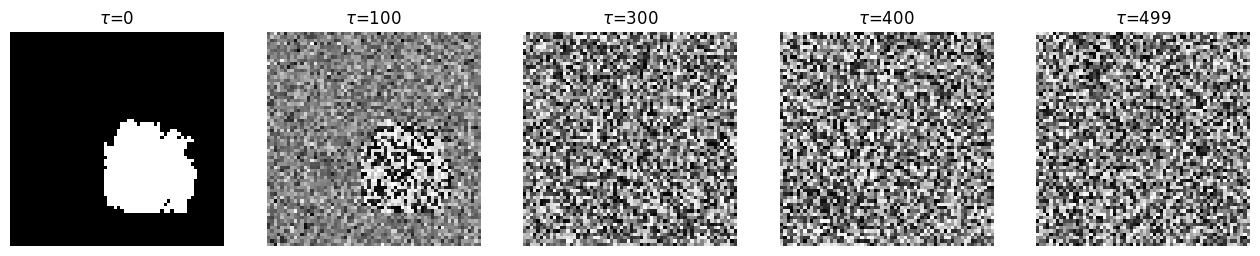

In [21]:
image = next(iter(train_loader))[0][0].squeeze()
conditional = next(iter(train_loader))[1][0].squeeze()

x_start = image.float()

gaussian_diffusion = Diffusion(timesteps=500, noise_schedule='cosine')

plt.figure(figsize=(16, 5))
for idx, t in enumerate([0, 100, 300, 400, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start.to(device), t=torch.tensor([t]).to(device))
    noisy_image = (x_noisy.squeeze() + 1) * 127.5
    if idx==0:
        noisy_image = (x_start.squeeze() + 1) * 127.5
    noisy_image = noisy_image.cpu().numpy().astype(np.uint8)
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image, cmap='gray')
    plt.axis("off")
    plt.title(f"$\\tau$={t}")
    

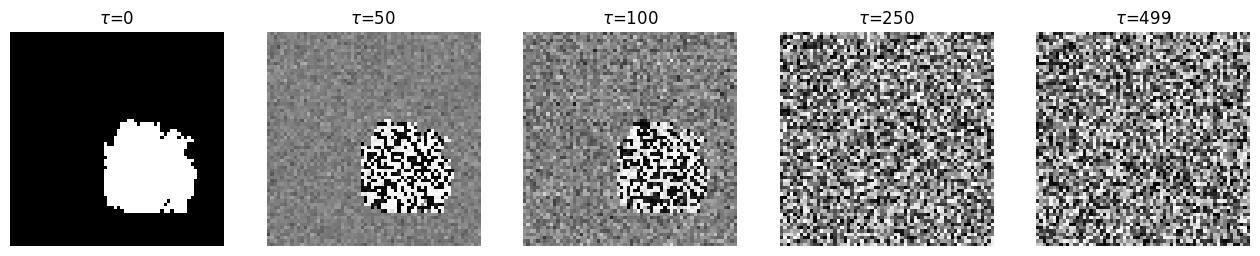

In [24]:
gaussian_diffusion = Diffusion(timesteps=500, noise_schedule='sigmoid')

plt.figure(figsize=(16, 5))
for idx, t in enumerate([0, 50, 100, 250, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start.to(device), t=torch.tensor([t]).to(device))
    noisy_image = (x_noisy.squeeze() + 1) * 127.5
    if idx==0:
        noisy_image = (x_start.squeeze() + 1) * 127.5
    noisy_image = noisy_image.cpu().numpy().astype(np.uint8)
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image, cmap='gray')
    plt.axis("off")
    plt.title(f"$\\tau$={t}")

In [19]:
# train
epochs = 20
p_uncound = 0.2
len_data = len(train_loader)
time_end = time.time()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

diff_losses = []
for epoch in range(epochs):
    epoch_diff_losses = []
    for step, (images, cond_images) in enumerate(train_loader):     
        time_start = time_end
        
        optimizer.zero_grad()
        
        batch_size = images.shape[0]
        images = images.to(device).float()
        cond_images = cond_images.to(device).float()
        
        # random generate mask
        z_uncound = torch.rand(batch_size)
        batch_mask = (z_uncound>p_uncound).int().to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        loss = gaussian_diffusion.train_losses(model, images, t, cond_images, batch_mask)

        epoch_diff_losses.append(loss.item())
        
        if step % 100 == 0:
            time_end = time.time()
            print("Epoch{}/{}\t  Step{}/{}\t Loss {:.4f}\t Time {:.2f}".format(epoch+1, epochs, step+1, len_data, loss.item(), time_end-time_start))
            
        loss.backward()
        optimizer.step()
        
    diff_losses.append(np.array(epoch_diff_losses).mean())

Epoch1/20	  Step1/422	 Loss 1.1409	 Time 12.63
Epoch1/20	  Step101/422	 Loss 0.0175	 Time 30.23
Epoch1/20	  Step201/422	 Loss 0.0126	 Time 25.04
Epoch1/20	  Step301/422	 Loss 0.0139	 Time 25.05
Epoch1/20	  Step401/422	 Loss 0.0120	 Time 25.05
Epoch2/20	  Step1/422	 Loss 0.0071	 Time 5.50
Epoch2/20	  Step101/422	 Loss 0.0116	 Time 25.06
Epoch2/20	  Step201/422	 Loss 0.0106	 Time 25.05
Epoch2/20	  Step301/422	 Loss 0.0080	 Time 25.07
Epoch2/20	  Step401/422	 Loss 0.0087	 Time 25.06
Epoch3/20	  Step1/422	 Loss 0.0106	 Time 5.48
Epoch3/20	  Step101/422	 Loss 0.0073	 Time 25.06
Epoch3/20	  Step201/422	 Loss 0.0079	 Time 25.07
Epoch3/20	  Step301/422	 Loss 0.0039	 Time 25.05
Epoch3/20	  Step401/422	 Loss 0.0059	 Time 25.04
Epoch4/20	  Step1/422	 Loss 0.0040	 Time 5.48
Epoch4/20	  Step101/422	 Loss 0.0049	 Time 25.05
Epoch4/20	  Step201/422	 Loss 0.0043	 Time 25.04
Epoch4/20	  Step301/422	 Loss 0.0041	 Time 25.05
Epoch4/20	  Step401/422	 Loss 0.0048	 Time 25.05
Epoch5/20	  Step1/422	 Loss 0.0

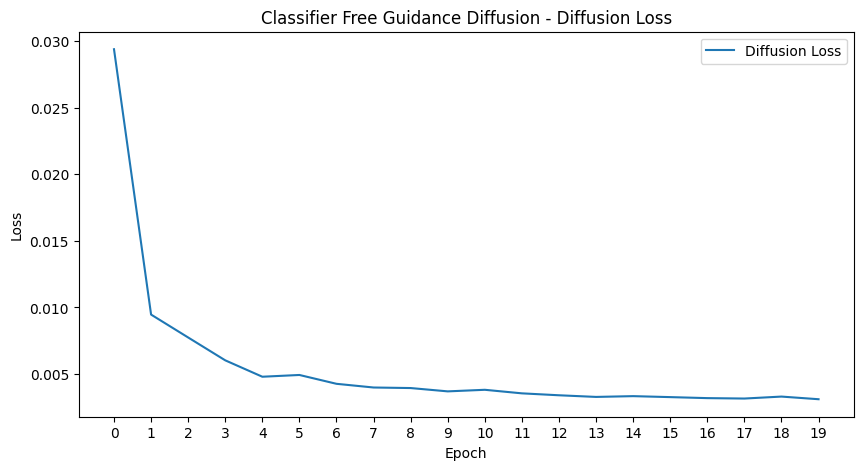

In [28]:
def plot_loss_curve(losses, title, epochs=20):
    xticks = list(range(epochs))
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Diffusion Loss')
    # plt.plot(total_loss, label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.xticks(xticks)
    plt.show()

# Example usage

plot_loss_curve(diff_losses, 'Classifier Free Guidance Diffusion - Diffusion Loss')

In [29]:
MODEL_SAVE_PATH = os.path.join(VOL_PATH, 'diss_ag/results/ckpts/gde_ensemble_model_4_64x64_simData_1000samples.h5')
torch.save(model, MODEL_SAVE_PATH)

In [27]:
model = torch.load(MODEL_SAVE_PATH)
gaussian_diffusion = Diffusion(timesteps=500, noise_schedule='linear')
print(model)

Unet(
  (time_emb): Sequential(
    (0): Linear(in_features=96, out_features=384, bias=True)
    (1): SiLU()
    (2): Linear(in_features=384, out_features=384, bias=True)
  )
  (downsample_blocks): ModuleList(
    (0): TimestepSeqEmbedding(
      (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepSeqEmbedding(
      (0): ResBlock(
        (conv_1): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (time_embedding): Sequential(
          (0): SiLU()
          (1): Linear(in_features=384, out_features=96, bias=True)
        )
        (condition_conv): Sequential(
          (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): SiLU()
        )
        (conv_2): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(

In [21]:
data_iter = iter(test_loader)
input_img, cond_img = next(data_iter)

# Ensure images are on the correct device and of type float32
input_img = input_img.to(device).float()
cond_img = cond_img.to(device).float()

# Define the image size and channels (modify as per your requirements)
image_size = input_img.shape[-1]
channels = input_img.shape[1]

# Call the sample method
generated_images = gaussian_diffusion.sample(
    model=model,
    image_size=image_size,
    cond_img=cond_img,
    batch_size=32,  # Set the desired batch size
    channels=channels,
    w=2,
    clip_denoised=True
)

sampling loop time step: 100%|████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.47it/s]


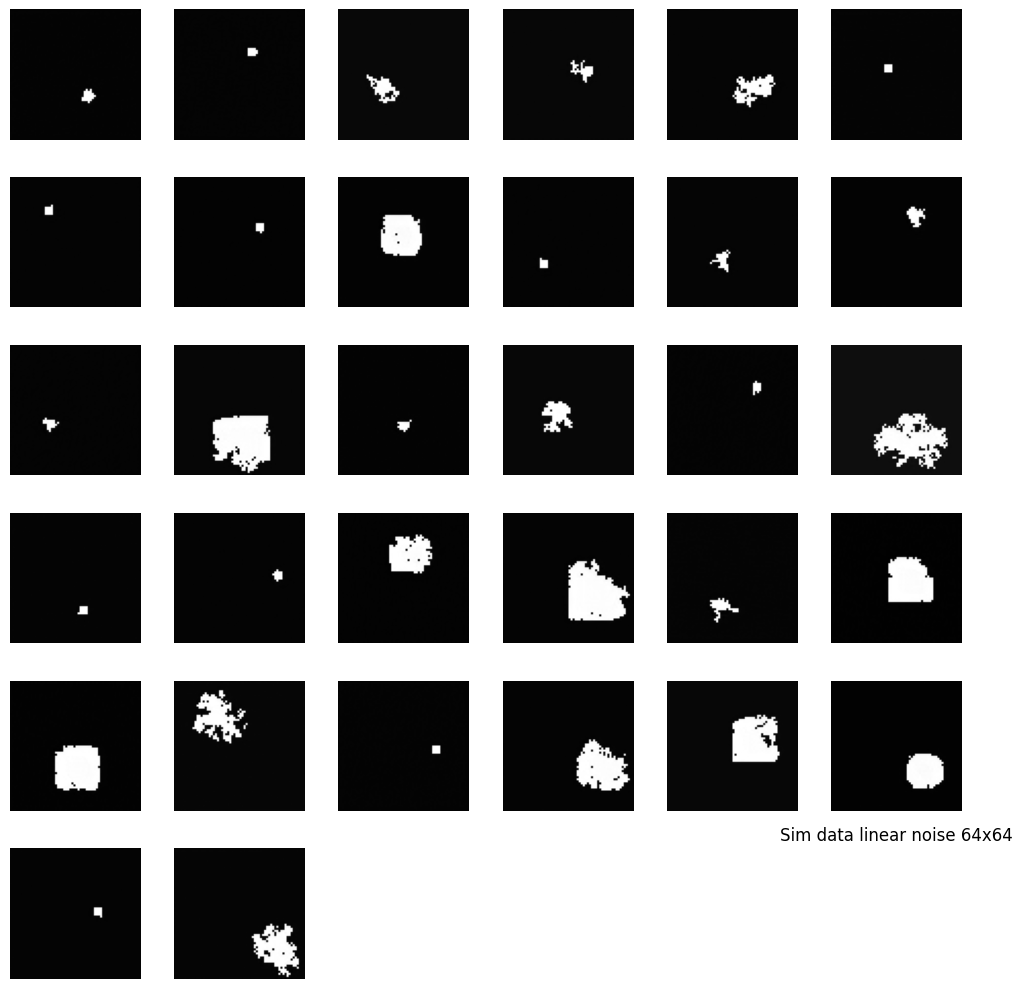

In [22]:
grid_size = int(np.ceil(np.sqrt(generated_images[-1].shape[0])))

# Plot the images
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Remove axis for each subplot
for ax in axes.flatten():
    ax.axis('off')

# Plot each image
for i, ax in enumerate(axes.flatten()):
    if i < generated_images[-1].shape[0]:
        ax.imshow(generated_images[-1][i].transpose(1, 2, 0), cmap='gray')

plt.title("Sim data linear noise 64x64")
plt.tight_layout()
plt.show()

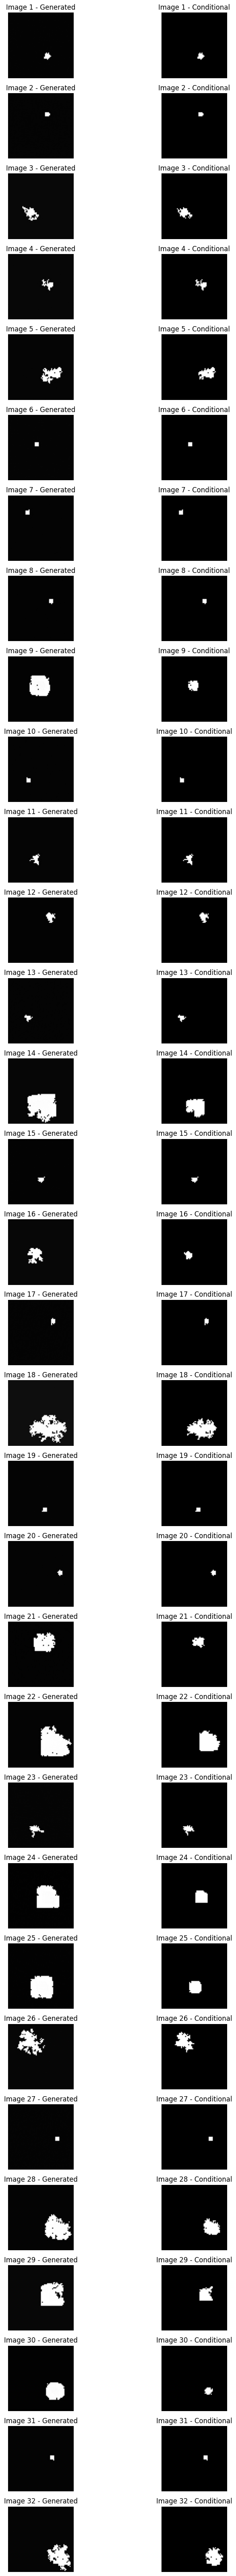

In [23]:
# Remove the channel dimension, shape becomes (32, 64, 64)
batch1 = generated_images[-1].squeeze(1)
batch2 = cond_img.cpu().numpy().squeeze(1)

# Define the grid size
num_images = batch1.shape[0]
grid_size = int(np.ceil(np.sqrt(num_images * 2)))

# Create subplots
fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 2))

# Plot pairs of images side by side
for i in range(num_images):
    # Original image from batch1
    axes[i, 0].imshow(batch1[i], cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Image {i+1} - Generated')

    # Corresponding image from batch2
    axes[i, 1].imshow(batch2[i], cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'Image {i+1} - Conditional')

plt.tight_layout()
plt.show()

#### Average Prediction From Diffusion Model

In [22]:
data_iter = iter(test_loader)
input_img, cond_img = next(data_iter)

# Ensure images are on the correct device and of type float32
input_img = input_img.to(device).float()
cond_img = cond_img.to(device).float()

# Define the image size and channels (modify as per your requirements)
image_size = input_img.shape[-1]
channels = input_img.shape[1]

# Call the sample method
coll_output = []
for i in range(10):
    generated_images = gaussian_diffusion.sample(
        model=model,
        image_size=image_size,
        cond_img=cond_img,
        batch_size=32,  # Set the desired batch size
        channels=channels,
        w=2,
        clip_denoised=True
    )
    coll_output.append(generated_images[-1].squeeze())

sampling loop time step: 100%|████████████████████████████████████████████████████████████| 500/500 [02:42<00:00,  3.08it/s]


sampling loop time step: 100%|████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 36.61it/s]


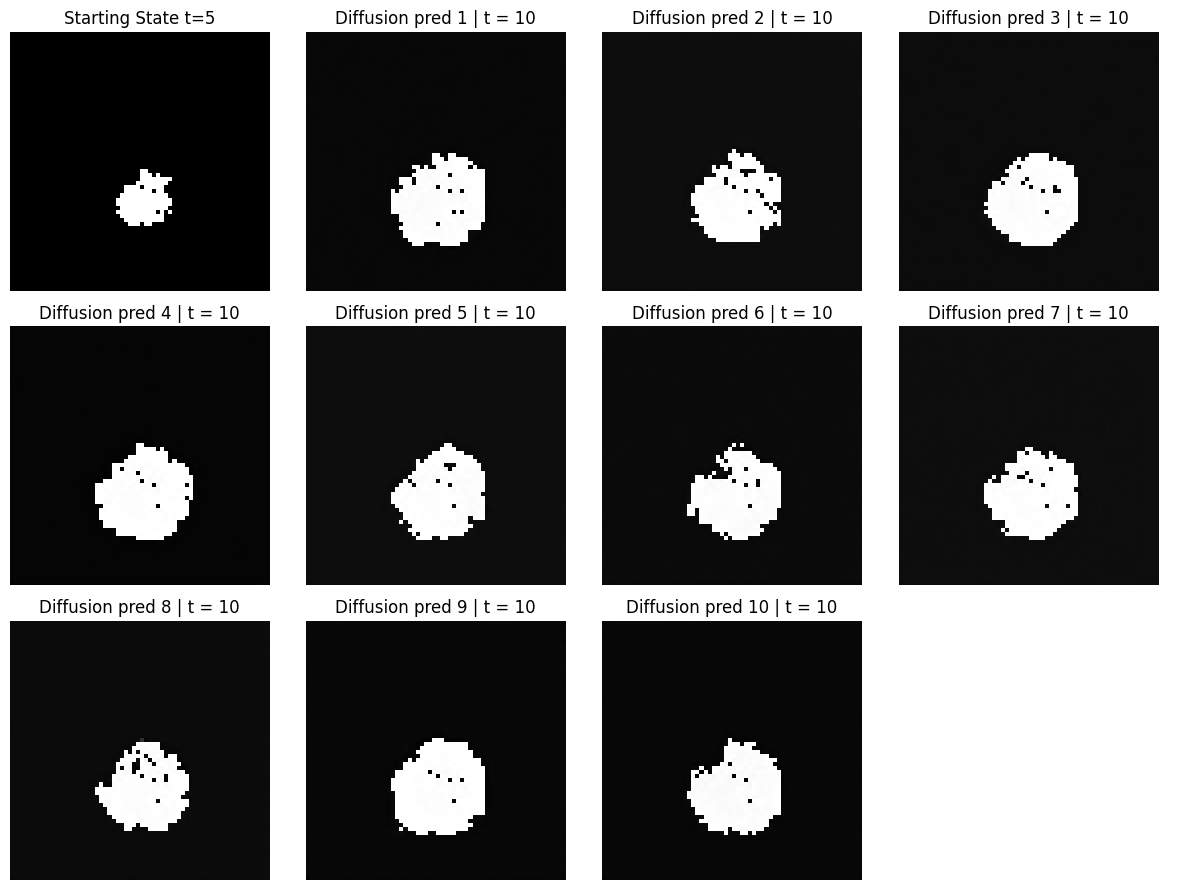

In [51]:
with open(os.path.join(VOL_PATH, "diss_ag/data/frame_data_dist/init_state_0_0.mppy"), 'rb') as f:
    init_state = pickle.load(f)
    init_state = np.where(init_state == 1, 0, init_state)
    init_state = np.where(init_state == 2, 0, init_state)
    init_state = np.where(init_state == 3, 1, init_state)
    init_state = np.where(init_state == 4, 1, init_state)

input_img_init = transform(init_state).to(device).float().unsqueeze(0)
image_size = input_img_init.shape[-1]
channels = input_img_init.shape[1]

generated_outputs = []
for i in range(10):
    generated_images = gaussian_diffusion.sample(
        model=model,
        image_size=image_size,
        cond_img=input_img_init,
        batch_size=1,  # Set the desired batch size
        channels=channels,
        w=2,
        clip_denoised=True
    )
    generated_outputs.append(generated_images[-1])

# Create a figure with a grid layout
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

# Plot the starting image
axes[0, 0].imshow(init_state, cmap="binary_r")
axes[0, 0].set_title('Starting State t=5')
axes[0, 0].axis('off')

# Plot the 10 predictions
for i in range(10):
    row = (i + 1) // 4
    col = (i + 1) % 4
    img = generated_outputs[i].squeeze().squeeze()
    axes[row, col].imshow(img, cmap="binary_r")
    axes[row, col].set_title(f'Diffusion pred {i + 1} | t = 10')
    axes[row, col].axis('off')

# Hide any unused subplots
for i in range(11, 12):
    row = i // 4
    col = i % 4
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [23]:
def mean_prediction(pred_arr):
    imgs = np.array(pred_arr)
    avg = np.mean(imgs, axis=0)
    
    return avg

mean_preds = mean_prediction(coll_output)

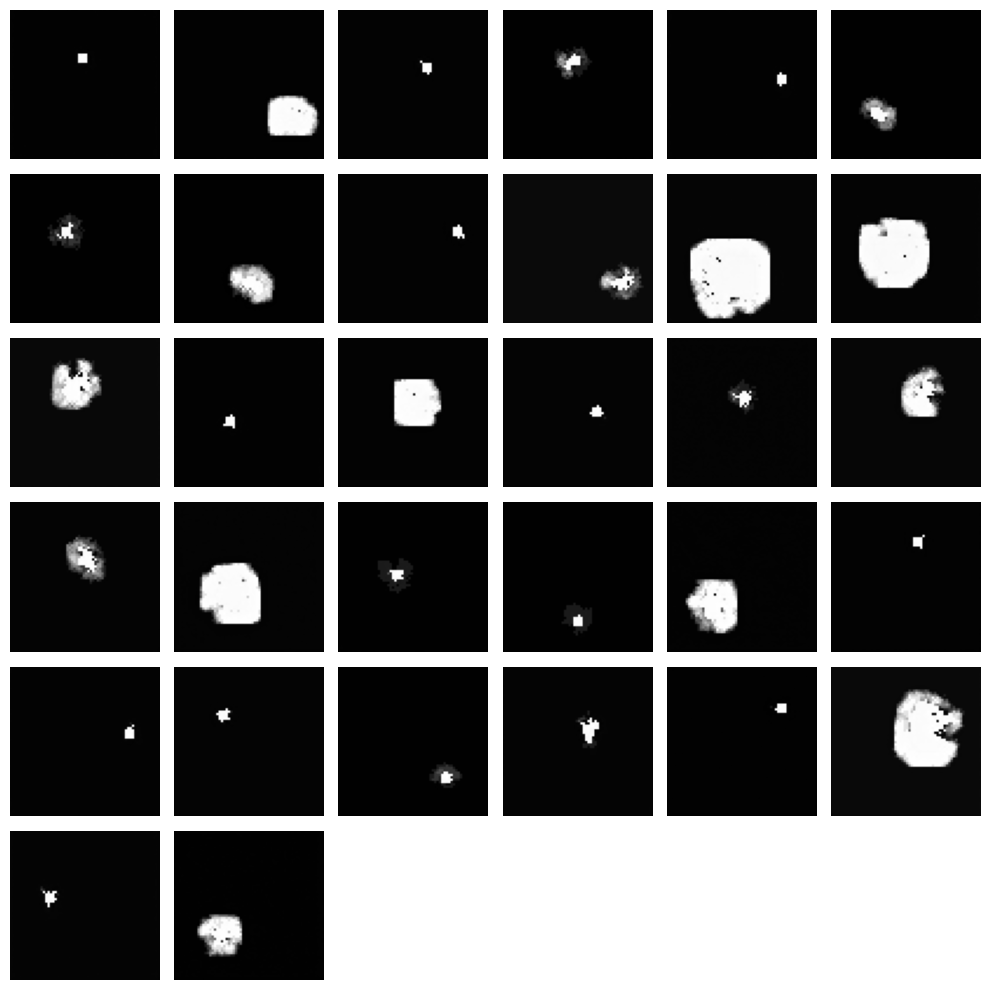

In [24]:
grid_size = int(np.ceil(np.sqrt(mean_preds.shape[0])))

# Plot the images
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Remove axis for each subplot
for ax in axes.flatten():
    ax.axis('off')

# Plot each image
for i, ax in enumerate(axes.flatten()):
    if i < mean_preds.shape[0]:
        ax.imshow(mean_preds[i], cmap='gray')

plt.tight_layout()
plt.show()

In [29]:
def adaptive_threshold(image, sigma=1.0, morph_size=3):
    # Normalize image to range [0, 1] from [-1, 1]
    normalized_image = (image + 1) / 2.0
    
    # Apply Gaussian filter to smooth the image (optional, helps with noise)
    smoothed_image = gaussian_filter(normalized_image, sigma=sigma)
    
    # Flatten the smoothed image
    pixel_values = smoothed_image.flatten().reshape(-1, 1)
    
    # Perform K-means clustering with 2 clusters
    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit(pixel_values)
    labels = kmeans.labels_
    
    # Determine which cluster is the light region
    cluster_means = kmeans.cluster_centers_.flatten()
    light_cluster = np.argmax(cluster_means)
    
    # Create a binary image based on the cluster labels
    binary_image = np.where(labels == light_cluster, 1, 0)
    binary_image = binary_image.reshape(normalized_image.shape)
    
    # Perform morphological operations to refine the regions
    binary_image = binary_opening(binary_image, structure=np.ones((morph_size, morph_size)))
    binary_image = binary_closing(binary_image, structure=np.ones((morph_size, morph_size)))
    
    return binary_image

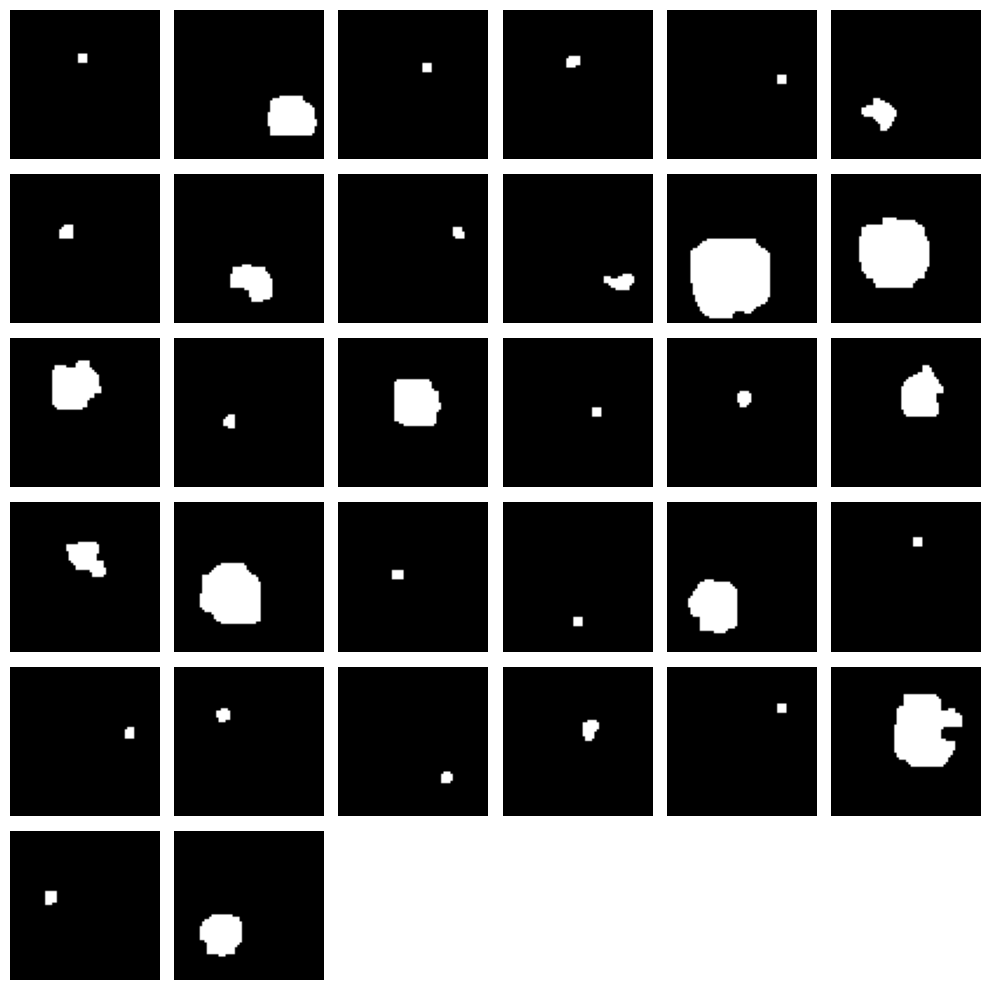

In [30]:
grid_size = int(np.ceil(np.sqrt(generated_images[-1].shape[0])))

# Plot the images
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Remove axis for each subplot
for ax in axes.flatten():
    ax.axis('off')

# Plot each image
for i, ax in enumerate(axes.flatten()):
    if i < generated_images[-1].shape[0]:
        img = generated_images[-1][i].squeeze()
        ax.imshow(adaptive_threshold(img), cmap='gray')

plt.tight_layout()
plt.show()

### Output refinement

tensor(0.6747) tensor(0.)


(-0.5, 63.5, 63.5, -0.5)

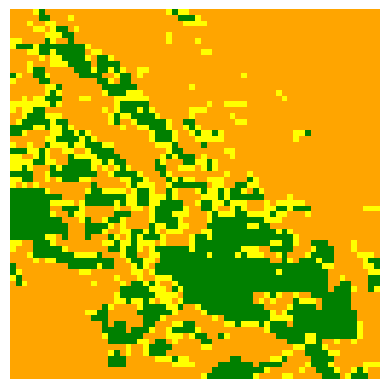

In [211]:
with open(os.path.join(VOL_PATH, "diss_ag/data/background.mpy"), 'rb') as f:
    background_img = pickle.load(f)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(64)
])
background_img = transform(background_img).squeeze()
print(background_img.max(), background_img.min())
plt.imshow(background_img, cmap=cmap, norm=norm, interpolation="None")
plt.axis("off")

(-0.5, 63.5, 63.5, -0.5)

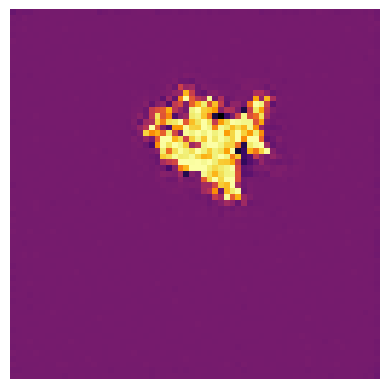

In [125]:
sam_img = generated_images[-1][6].squeeze()
# sam_img = adaptive_threshold(sam_img, sigma=0.9)
plt.imshow(sam_img, cmap="inferno")
plt.axis("off")

(-0.5, 63.5, 63.5, -0.5)

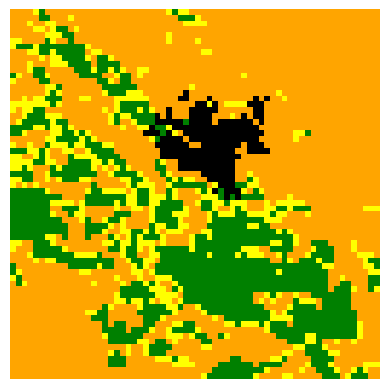

In [209]:
cmap = mpl.colors.ListedColormap(['orange','yellow', 'green', 'black'])
cmap.set_over('0.25')
cmap.set_under('0.75')
bounds = [0, 0.28, 0.35, 0.68, 1.1] #[0, 0.25, 0.31, 0.68, 1.1]
# bounds = [1.0, 2.02, 2.27, 3.5, 5.1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


# Create an overlay image
overlay_image = copy.deepcopy(background_img)

# Overlay the binary image on the second image
overlay_image[sam_img >= 0.5] = 1  # Setting the region to 1

plt.imshow(overlay_image, cmap=cmap, norm=norm, interpolation="None")
plt.axis("off")

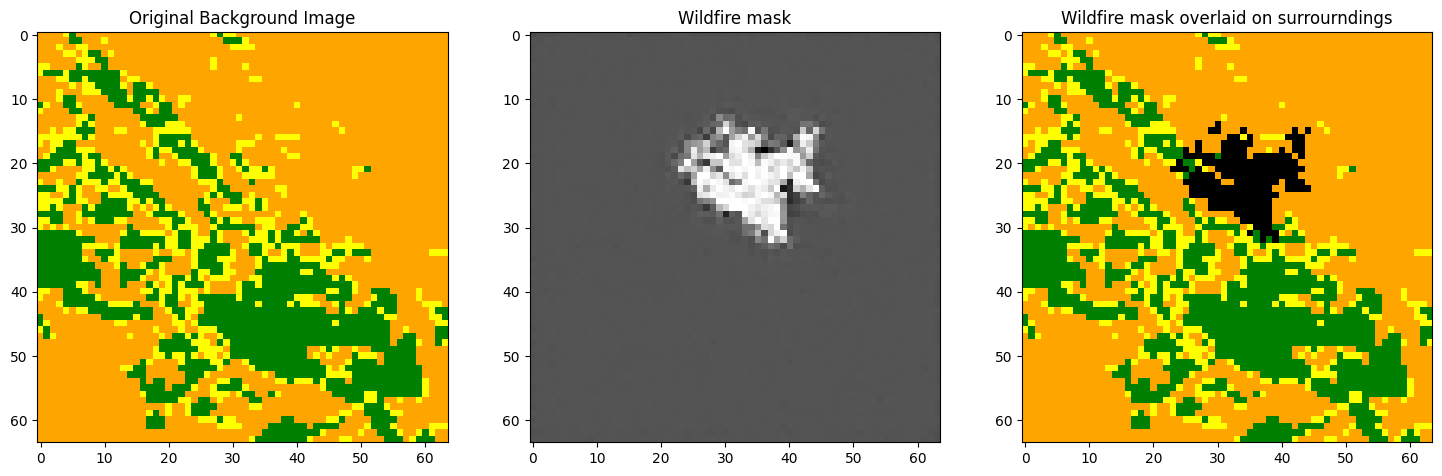

In [210]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Original background image
ax[0].imshow(background_img, cmap=cmap, norm=norm)
ax[0].set_title('Original Background Image')

# Mask overlay on the background
ax[1].imshow(sam_img, cmap="binary_r")  # Plot the original background
ax[1].set_title('Wildfire mask')

# Blended image with transparent surroundings
ax[2].imshow(overlay_image, cmap=cmap, norm=norm, interpolation="None")  # Blend the overlay image using alpha mask
ax[2].set_title('Wildfire mask overlaid on surrourndings')

plt.show()